# Food Delivery | XGBoost - LightGBM - SckitLearn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import norm
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import linear_model

In [8]:
# Cargamos el dataset
df = pd.read_csv("Kaggle/LinearRegression/FoodDelivery/Food_Delivery_Times.csv")

In [9]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [11]:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


<hr>

### Duplicados

In [13]:
print(f'Numero de duplicados del dataset: {df.duplicated().sum()}')

Numero de duplicados del dataset: 0


### Valores nulos (missing values)

In [16]:
for i in df:
    if df[i].isnull().sum()>0:
        print(f'{i} tiene: {df[i].isnull().sum()} valores nulos')

Weather tiene: 30 valores nulos
Traffic_Level tiene: 30 valores nulos
Time_of_Day tiene: 30 valores nulos
Courier_Experience_yrs tiene: 30 valores nulos


### Corregimos los valores nulos

In [17]:
# Reemplazo los valores nulos por el dato mas fercuente
df['Weather'] = df ['Weather'].fillna(df['Weather'].mode()[0])
df['Traffic_Level'] = df['Traffic_Level'].fillna(df['Traffic_Level'].mode()[0])
df['Time_of_Day'] = df['Time_of_Day'].fillna(df['Time_of_Day'].mode()[0])

#Calcula el valor central de los datos ordenados.
df['Courier_Experience_yrs'] = df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].median())

In [18]:
#comprobamos los nulos
df.isnull().sum()

Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

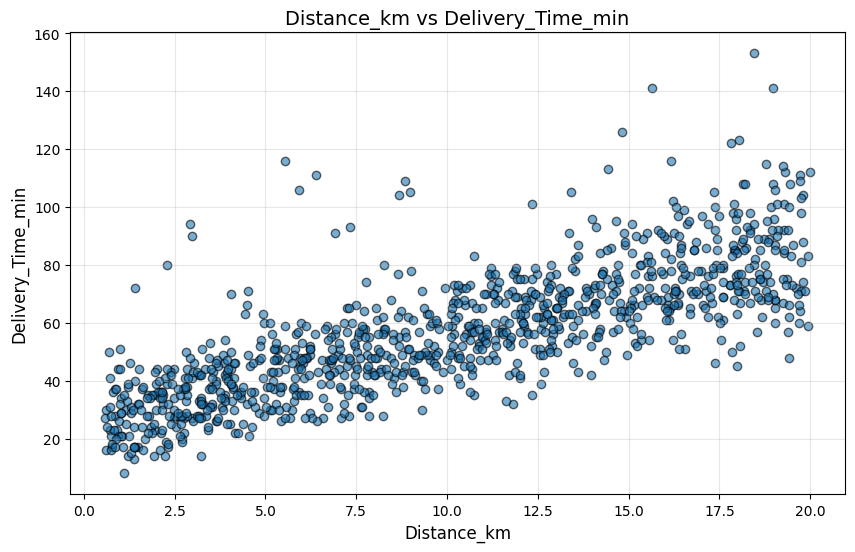

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Distance_km"], df["Delivery_Time_min"], alpha=0.6, edgecolor='k')
plt.title("Distance_km vs Delivery_Time_min", fontsize=14)
plt.xlabel("Distance_km", fontsize=12)
plt.ylabel("Delivery_Time_min", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

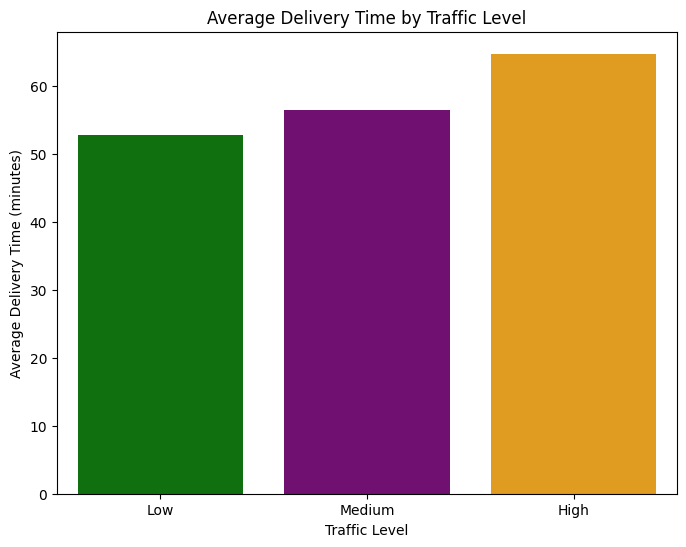

In [23]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Traffic_Level', y='Delivery_Time_min', data=df, errorbar=None, hue='Traffic_Level', palette = {'Low': "green", 'Medium': "purple", 'High': 'orange'})
plt.title("Average Delivery Time by Traffic Level")
plt.xlabel("Traffic Level")
plt.ylabel("Average Delivery Time (minutes)")
plt.show()

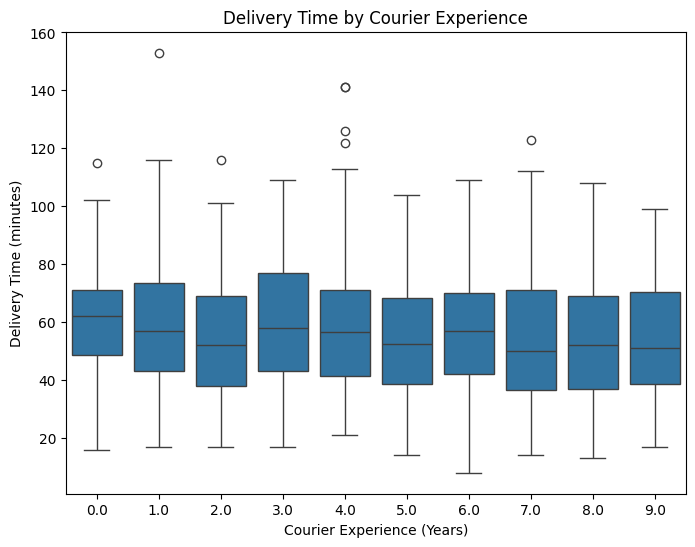

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Courier_Experience_yrs', y='Delivery_Time_min', data=df)
plt.title("Delivery Time by Courier Experience")
plt.xlabel("Courier Experience (Years)")
plt.ylabel("Delivery Time (minutes)")
plt.show()

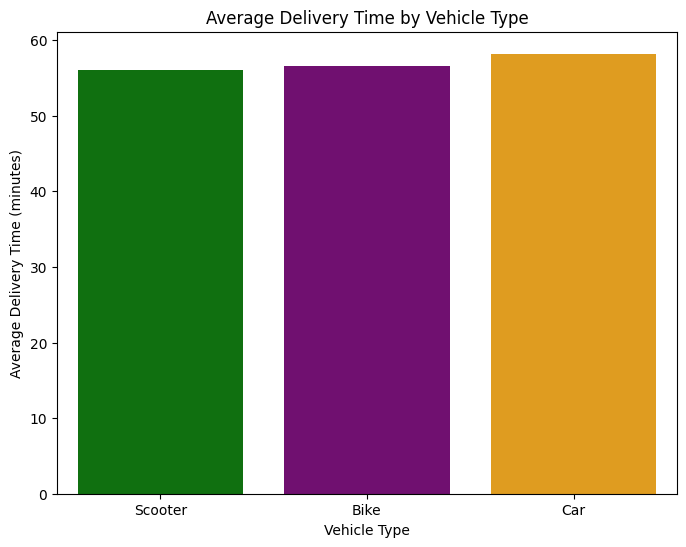

In [22]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Vehicle_Type', y='Delivery_Time_min', data=df, errorbar=None, hue='Vehicle_Type', palette = {'Scooter': "green", 'Bike': "purple", 'Car': 'orange'})
plt.title("Average Delivery Time by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Average Delivery Time (minutes)")
plt.show()

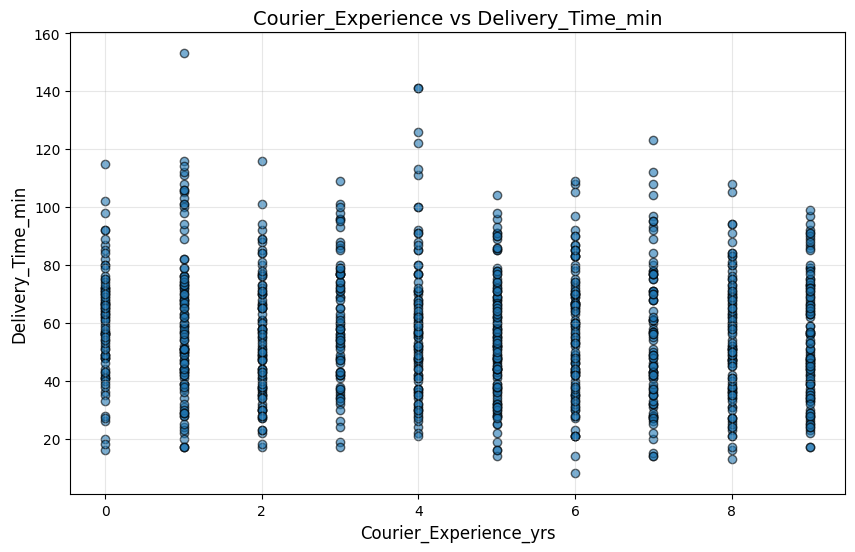

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Courier_Experience_yrs"], df["Delivery_Time_min"], alpha=0.6, edgecolor='k')
plt.title("Courier_Experience vs Delivery_Time_min", fontsize=14)
plt.xlabel("Courier_Experience_yrs", fontsize=12)
plt.ylabel("Delivery_Time_min", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

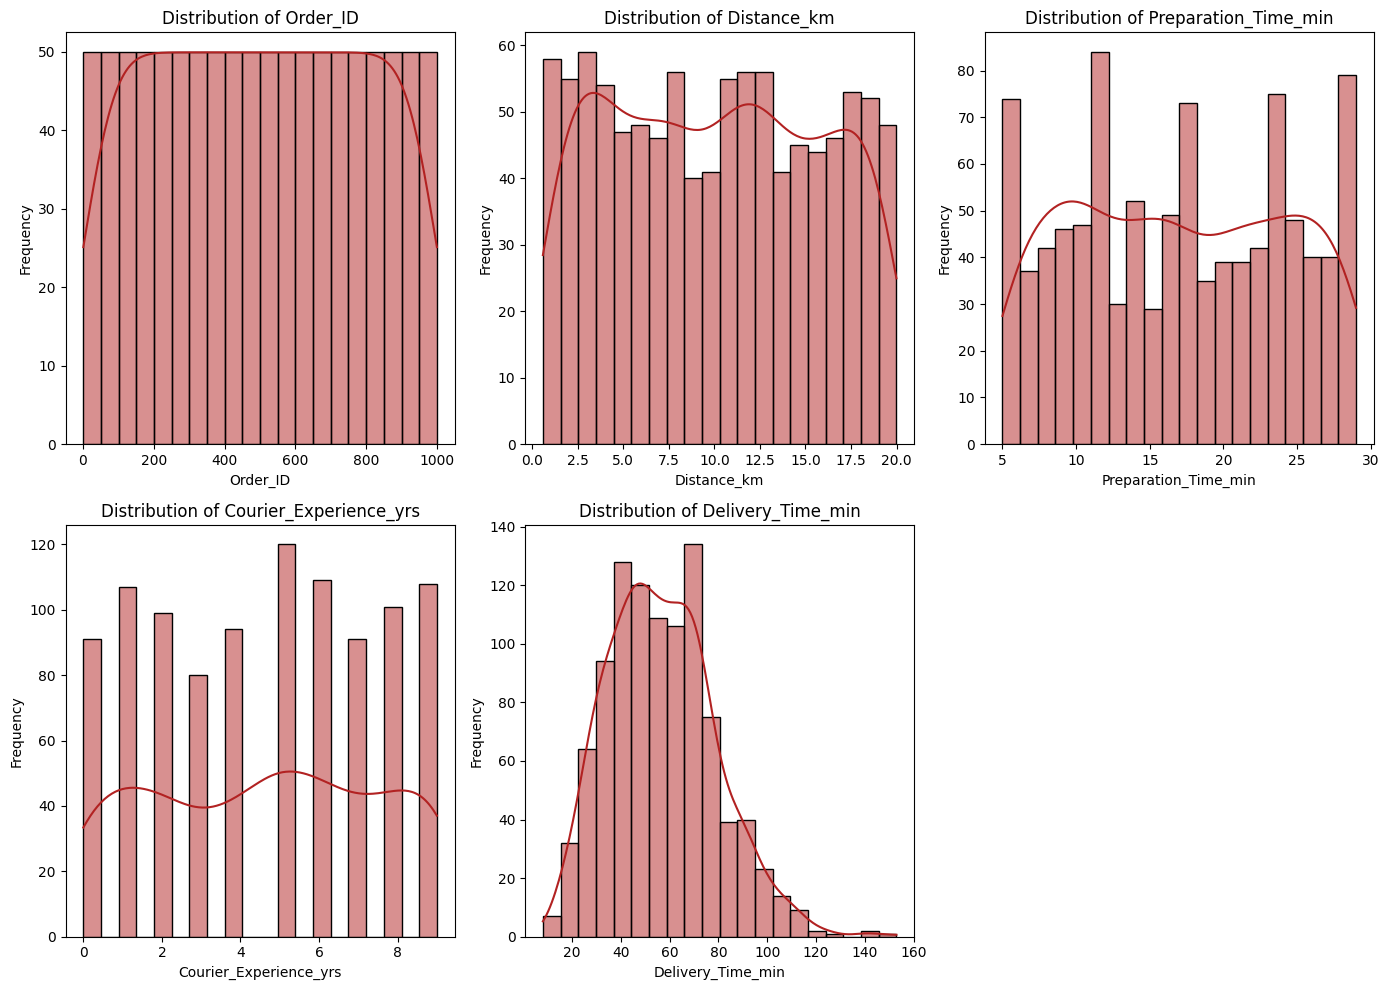

In [25]:
# Crea una lista con los nombres de todas las columnas numéricas 
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    #Calcula el número de filas necesarias para mostrar todas las columnas en grupos de 3.
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i)
    sns.histplot(df[col], kde=True, bins=20, color='firebrick')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Spearman Correlation

                        Order_ID  Distance_km  Preparation_Time_min  \
Order_ID                1.000000    -0.023792             -0.035362   
Distance_km            -0.023792     1.000000             -0.009025   
Preparation_Time_min   -0.035362    -0.009025              1.000000   
Courier_Experience_yrs  0.012912    -0.005951             -0.031124   
Delivery_Time_min      -0.033831     0.816535              0.305535   

                        Courier_Experience_yrs  Delivery_Time_min  
Order_ID                              0.012912          -0.033831  
Distance_km                          -0.005951           0.816535  
Preparation_Time_min                 -0.031124           0.305535  
Courier_Experience_yrs                1.000000          -0.085540  
Delivery_Time_min                    -0.085540           1.000000  


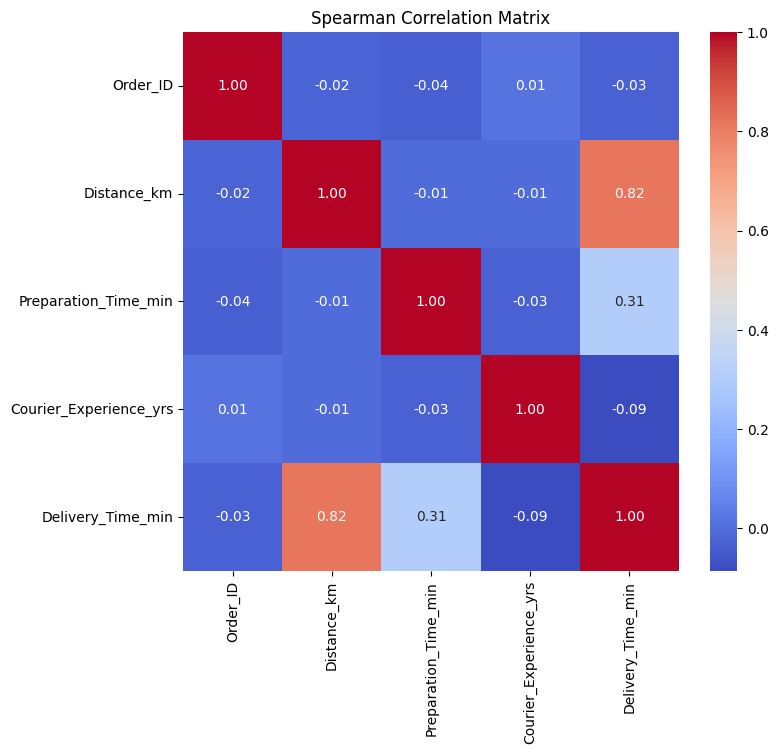

In [26]:
numeric_df = df.select_dtypes(include=['number'])
# Spearman mide la relación monótona entre dos variables,como cambian juntas sin asumir linealidad.
spearman_corr = numeric_df.corr(method='spearman')

# Generar la matriz de correlación
print(spearman_corr)

# Construyendo un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(8, 7))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Spearman Correlation Matrix')
plt.show()

<hr>

### Preparación de los datos

Empleando el One-hot encoding ya que posee el dataset muchos valores nominales

In [27]:
# Transforma columnas categóricas en nuevas columnas binarias.
# Evita el problema de multicolinealidad al eliminar la primera categoría de cada columna
df2 = pd.get_dummies(df, columns=['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'],
                    drop_first=True)


In [28]:
df2.head()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_Low,Traffic_Level_Medium,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter
0,522,7.93,12,1.0,43,False,False,False,True,True,False,False,False,False,False,True
1,738,16.42,20,2.0,84,False,False,False,False,False,True,True,False,False,False,False
2,741,9.52,28,1.0,59,True,False,False,False,True,False,False,False,True,False,True
3,661,7.44,5,1.0,37,False,True,False,False,False,True,False,False,False,False,True
4,412,19.03,16,5.0,68,False,False,False,False,True,False,False,True,False,False,False


In [32]:
df2.shape

(1000, 16)

In [41]:
# Elimina las columnas(axis=1) especificadas en la lista
X = df2.drop(['Order_ID', 'Delivery_Time_min'], axis = 1)
#Esta variable objetivo contiene los valores reales intentará predecir.
y = df2['Delivery_Time_min']

In [42]:
# X_train: Contiene las características (features) del conjunto de entrenamiento
# x_test: Contiene las características del conjunto de prueba.
# y_train: Contiene los valores de la variable objetivo (target) correspondientes a X_train.
# y_test: Contiene los valores de la variable objetivo correspondientes a X_test
# test_size: 30% para test y 70% entrenar
#random_state: semilla para el generador de números aleatorios
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=250)

En caso de no usar XGBoost o LightGBM:

In [43]:
# Crea un objeto de tipo StandardScaler que se encargará de estandarizar los datos.
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test) 

<hr>

### Machine Learning
- #### XGBoost
XGBRegressor es un modelo de regresión basado en Gradient Boosting (XGBoost) que combina múltiples árboles de decisión secuencialmente para minimizar el error.

Entrena el modelo XGBRegressor para todas las combinaciones de los hiperparámetros especificados en param_xgb usando los datos de entrenamiento.

In [44]:
#objective='reg:squarederror': Define la función de pérdida para la regresión
#eval_metric: Usa el Error Absoluto Medio (MAE)
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae')

#Este diccionario especifica los valores a probar para los hiperparámetros clave
# n_estimators: Número de árboles en el modelo. Más árboles pueden mejorar el ajuste.
# learning_rate: Tasa de aprendizaje. Valores más pequeños requieren más árboles.
# max_depth:Profundidad máxima de los árboles. Controla la complejidad y previene el sobreajuste.
# subsample:Proporción de muestras usadas para entrenar cada árbol. Reduce el sobreajuste si es menor que 1.
# min_child_weight:Peso mínimo de las hojas. Valores mayores aumentan el requisito de datos para una división
param_xgb = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.1, 0.2],  
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]    
}

# Realiza una búsqueda exhaustiva de las combinaciones de los hiperparámetros en param_xgb.
# Usa 4 partes para entrenar y 1 para validar, repitiendo esto 5 veces
grid_search__xgb = GridSearchCV(xgb_regressor, param_xgb, cv=5, error_score='raise')

# Entrena el modelo
grid_search__xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric='mae',
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]})

El atributo best_params_ de un objeto GridSearchCV te devuelve el conjunto de hiperparámetros que resultaron ser los mejores según la búsqueda realizada. 

In [45]:
grid_search__xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 50,
 'subsample': 0.8}

el modelo entrenado con la mejor combinación de parámetros que se ha identificado en la búsqueda de hiperparámetros.

In [46]:
# Obtener el mejor modelo ajustado con los mejores parámetros
best_gs_xgb_two = grid_search__xgb.best_estimator_

# Imprimir el modelo
print(best_gs_xgb_two)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [47]:
#Esto genera las predicciones del modelo sobre los datos de prueba X_test.
y_test_pred1 = best_gs_xgb_two.predict(X_test)
#Calcula el error absoluto medio entre las etiquetas reales y_test y las predicciones y_test_pred1.
mae_test = mean_absolute_error(y_test, y_test_pred1)

#ste valor indica qué tan bien el modelo puede explicar la variación en los datos. 
#Un valor cercano a 1 indica un buen ajuste, mientras que un valor cercano a 0 indica un ajuste pobre.
print('Score on train data = ', round(best_gs_xgb_two.score(X_train, y_train), 4))
print('Score on test data = ', round(best_gs_xgb_two.score(X_test, y_test), 4))
#Imprime el MAE de las predicciones sobre los datos de prueba
print('MAE on test data =', round(mae_test, 4))

Score on train data =  0.8036
Score on test data =  0.8003
MAE on test data = 6.7233


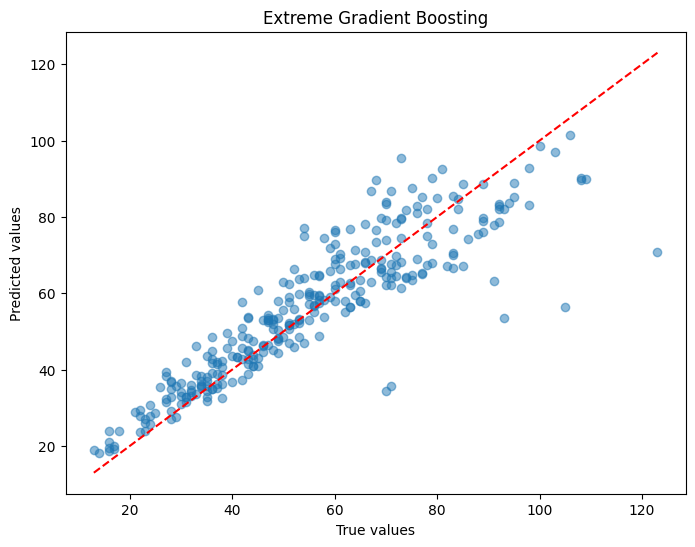

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred1, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Extreme Gradient Boosting')
plt.show()

- #### LightGBM

In [49]:
lgb_regressor = lgb.LGBMRegressor(objective='regression', metric='mae', verbose=-1)

param_lgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3, 5],
}

grid_search_lgb = GridSearchCV(lgb_regressor, param_lgb, cv=5, scoring='neg_mean_absolute_error')

grid_search_lgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LGBMRegressor(metric='mae', objective='regression',
                                     verbose=-1),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 10], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [31, 50, 100], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error')

In [50]:
print('Best params:', grid_search_lgb.best_params_)

Best params: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}


In [52]:
best_lgb = grid_search_lgb.best_estimator_

In [53]:
y_test_pred2 = best_lgb.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred2)

print('Score on train data:', round(best_lgb.score(X_train, y_train), 4))
print('Score on test data:', round(best_lgb.score(X_test, y_test), 4))
print('MAE on test data:', round(mae_test, 4))

Score on train data: 0.817
Score on test data: 0.792
MAE on test data: 6.7521


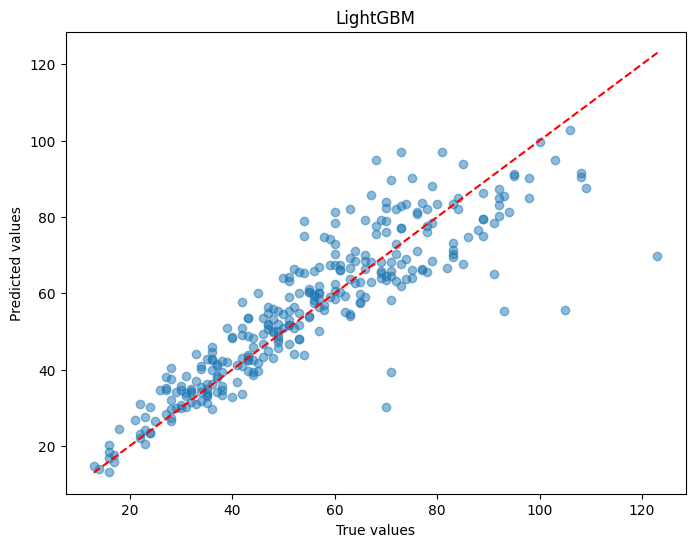

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred2, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('LightGBM')
plt.show()

### Best model : XGBoost